In [10]:
import sys
sys.path.append('../Phase_2')            # point Python at your Phase_2 folder
from Phase_2 import Phase2Pipeline

import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

# === Load Classifier and Regressors ===
classifier = joblib.load('../Phase_2/stage_classifier_pipeline.pkl')
rf_model = joblib.load('../Phase_3/random_forest_model.pkl')
ridge_model = joblib.load('../Phase_3/ridge_model.pkl')
svr_model = joblib.load('../Phase_3/svr_model.pkl')

# === Load Test Data ===
X_test = pd.read_csv('../Phase_3/X_test.csv')
y_test = pd.read_csv('../Phase_3/y_test.csv')

In [11]:
# Use raw sensor columns for classifier
classifier_features = [
    'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 7', 'Sensor 9', 'Sensor 11',
    'Sensor 12', 'Sensor 14', 'Sensor 15', 'Sensor 17', 'Sensor 20', 'Sensor 21'
]
X_test_classifier = X_test[classifier_features]
X_test_regressors = X_test  # all features

#  Predict Failure Probabilities
### Use the classifier to predict the probability of failure (Stage 4):

In [12]:
stage_probs = classifier.predict_proba(X_test_classifier)
stage_4_probs = stage_probs[:, 3]  # adjust if stage index differs


# Predict Time Left to Failure
### Use all 2 regressors to predict time left (assuming ridge is just a bad model):

In [13]:
rf_preds = rf_model.predict(X_test_regressors)
svr_preds = svr_model.predict(X_test_regressors)
avg_time_left = (rf_preds + svr_preds) / 2


# Compute Risk Score

In [14]:
raw_risk_scores = stage_4_probs * avg_time_left


### Optionally, compute an urgency score (alternative):

In [15]:
urgency_score = stage_4_probs / (avg_time_left + 1e-6)


# Normalize Risk Score
### Min-Max Normalization:

In [16]:
min_score = np.min(raw_risk_scores)
max_score = np.max(raw_risk_scores)
normalized_scores = (raw_risk_scores - min_score) / (max_score - min_score + 1e-6)

# Generate Maintenance Alerts
### Use a threshold to flag high-risk engines:

In [17]:
'''alerts = normalized_scores > 0.7
for i, alert in enumerate(alerts):
    if alert:
        print(f"⚠️ Maintenance Alert for Sample {i} | Score: {normalized_scores[i]:.3f}")'''

'alerts = normalized_scores > 0.7\nfor i, alert in enumerate(alerts):\n    if alert:\n        print(f"⚠️ Maintenance Alert for Sample {i} | Score: {normalized_scores[i]:.3f}")'

# Visualize Risk Scores Over Time

In [18]:
df_full = pd.read_csv('../Phase_1/train_FD001_phase_1.csv')  # or correct path

# Fix column names if needed
df_full.rename(columns={'Num cycles': 'cycle'}, inplace=True)

In [19]:
# Add predictions and scores to tail
df_tail = df_full.tail(len(X_test)).copy()
df_tail['Failure_Prob'] = stage_4_probs
df_tail['Avg_Time_Left'] = avg_time_left
df_tail['Raw_Risk_Score'] = raw_risk_scores
df_tail['Normalized_Risk_Score'] = normalized_scores
df_tail['Urgency_Risk_Score'] = urgency_score
df_tail['Maintenance_Alert'] = normalized_scores > 0.7


# Plotting Normalized Risk Score Trend

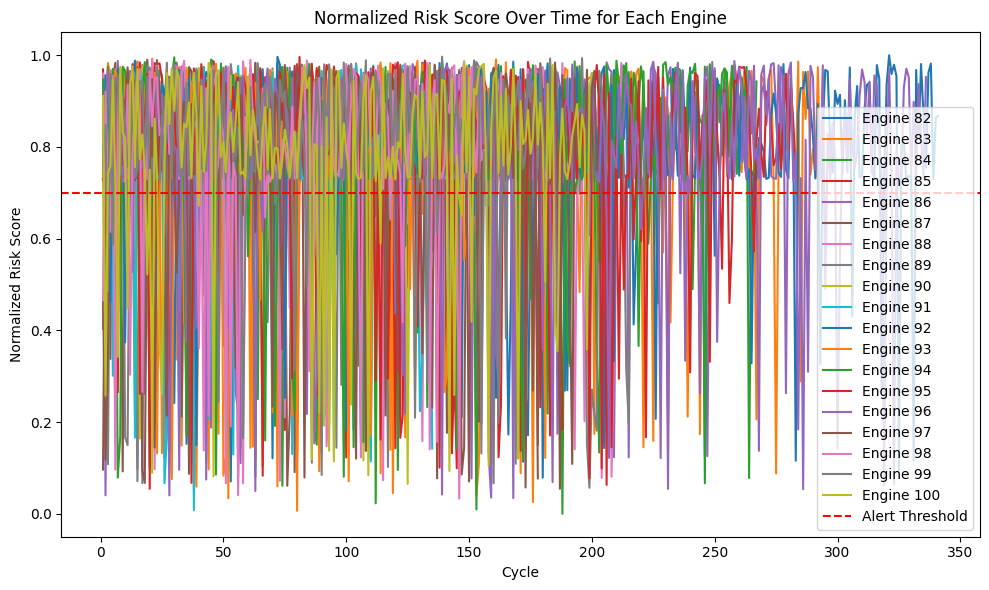

In [20]:
plt.figure(figsize=(10, 6))
for engine in df_tail['Engine no'].unique():
    engine_data = df_tail[df_tail['Engine no'] == engine]
    plt.plot(engine_data['cycle'], engine_data['Normalized_Risk_Score'], label=f'Engine {engine}')

plt.xlabel('Cycle')
plt.ylabel('Normalized Risk Score')
plt.title('Normalized Risk Score Over Time for Each Engine')
plt.axhline(0.7, color='red', linestyle='--', label='Alert Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting Urgency Risk Score Trend

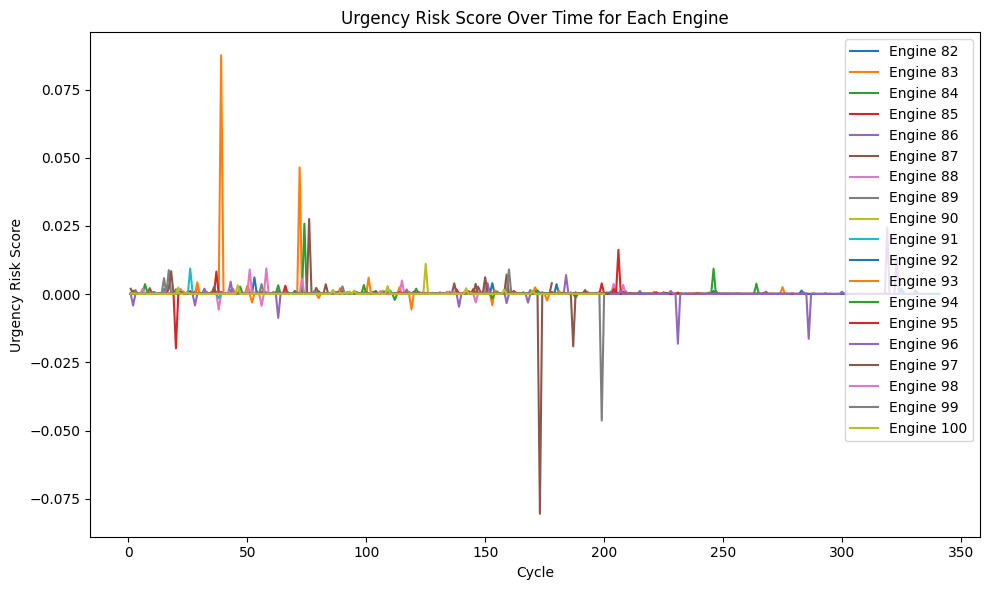

In [21]:
plt.figure(figsize=(10, 6))
for engine in df_tail['Engine no'].unique():
    engine_data = df_tail[df_tail['Engine no'] == engine]
    plt.plot(engine_data['cycle'], engine_data['Urgency_Risk_Score'], label=f'Engine {engine}')

plt.xlabel('Cycle')
plt.ylabel('Urgency Risk Score')
plt.title('Urgency Risk Score Over Time for Each Engine')
plt.legend()
plt.tight_layout()
plt.show()

# 1. Inspect the Distribution of Your Normalized Scores
### Before picking a threshold, let’s visualize how your scores are spread out:


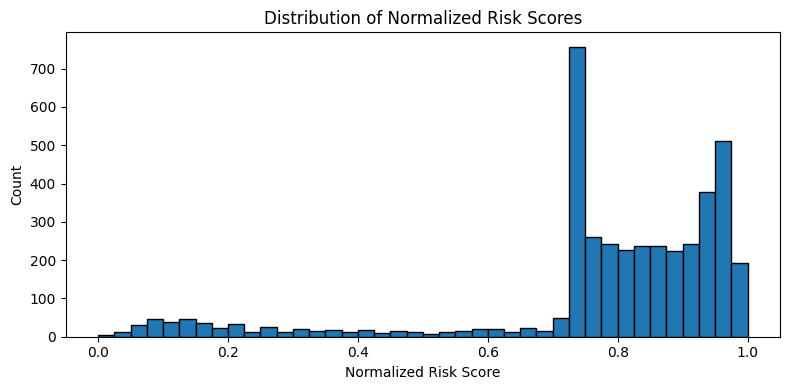

In [22]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(normalized_scores, bins=40, edgecolor='k')
plt.title("Distribution of Normalized Risk Scores")
plt.xlabel("Normalized Risk Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### If you see most scores clustered above 0.7, you know the fixed cutoff is too low.

# 2. Choose a Dynamic Threshold
### a) Percentile-based threshold
### E.g. flag the top 10% riskiest samples:


In [23]:

threshold = np.percentile(normalized_scores, 80)  # 90th percentile
print(f"Using 90th‐percentile threshold = {threshold:.3f}")

alerts = normalized_scores > threshold
df_tail['Maintenance_Alert'] = alerts


Using 90th‐percentile threshold = 0.943


In [24]:
alerts = normalized_scores > threshold
count = 0
for i, alert in enumerate(alerts):
    if alert:
        # print(f"⚠️ Maintenance Alert for Sample {i} | Score: {normalized_scores[i]:.3f}")
        count = count + 1
print(count)

825


#### You can adjust 90 to 80, 95, etc., depending on how many engines you want to flag.

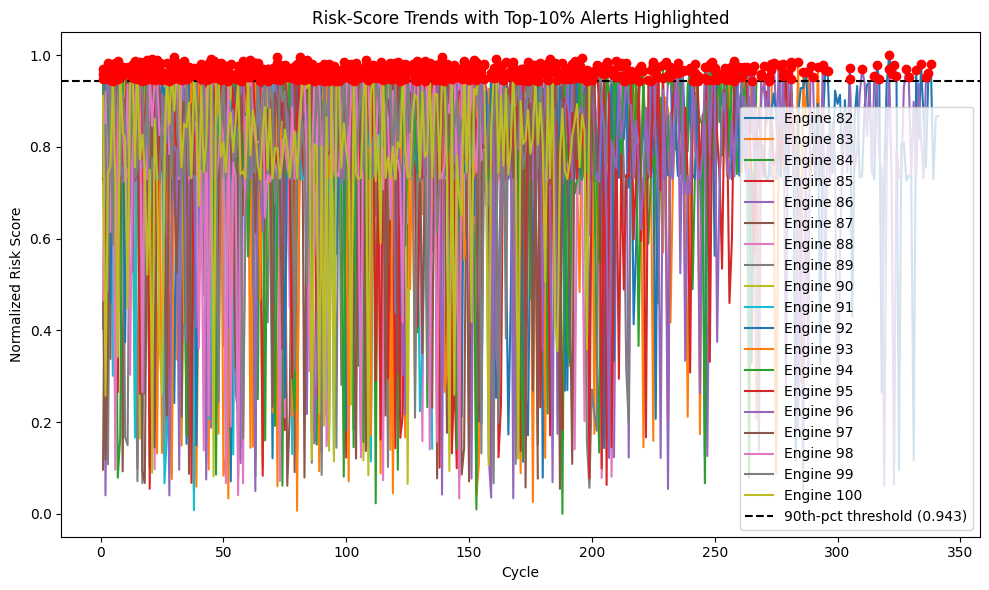

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for engine in df_tail['Engine no'].unique():
    eng = df_tail[df_tail['Engine no'] == engine]
    plt.plot(eng['cycle'], eng['Normalized_Risk_Score'], label=f'Engine {engine}')
    # highlight alert points
    over = eng[eng['Normalized_Risk_Score'] > threshold]
    plt.scatter(over['cycle'], over['Normalized_Risk_Score'], color='red', zorder=5)

plt.axhline(threshold, color='black', linestyle='--', label=f'90th-pct threshold ({threshold:.3f})')
plt.xlabel('Cycle')
plt.ylabel('Normalized Risk Score')
plt.title('Risk‐Score Trends with Top‐10% Alerts Highlighted')
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
alerts = normalized_scores > threshold
count = 0
for i, alert in enumerate(alerts):
    if alert:
        # print(f"⚠️ Maintenance Alert for Sample {i} | Score: {normalized_scores[i]:.3f}")
        count = count + 1
print(count)

825


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# 1) Inspect raw‐risk and urgency ranges
print(f"Raw risk range:  min={raw_risk_scores.min():.3f}, max={raw_risk_scores.max():.3f}")
print(f"Urgency range:   min={urgency_score.min():.3f},   max={urgency_score.max():.3f}")

# 2) Compute normalized (again) and urgency
# (you already have normalized_scores, urgency_score)

# 3) Build y_true from y_test (< k cycles)
k = 10
y_true = (y_test.values.flatten() < k).astype(int)
print("y_true distribution:", dict(zip(*np.unique(y_true, return_counts=True))))

# --- Try Youden’s‐J on normalized_scores ---
fpr_n, tpr_n, cuts_n = roc_curve(y_true, normalized_scores)
j_n = tpr_n - fpr_n
best_idx_n = np.argmax(j_n)
youden_cut_n = cuts_n[best_idx_n]
# Check validity: Youden’s‐J only meaningful if j_n.max()>0
if j_n.max() > 0:
    cut_norm = youden_cut_n
    print(f"Youden’s‐J cutoff (norm) = {cut_norm:.3f}")
else:
    cut_norm = np.percentile(normalized_scores, 90)
    print(f"Fallback 90th-pct cutoff (norm) = {cut_norm:.3f}")

# --- Try Youden’s‐J on urgency_score ---
fpr_u, tpr_u, cuts_u = roc_curve(y_true, urgency_score)
j_u = tpr_u - fpr_u
best_idx_u = np.argmax(j_u)
youden_cut_u = cuts_u[best_idx_u]
if j_u.max() > 0:
    cut_urg = youden_cut_u
    print(f"Youden’s‐J cutoff (urgency) = {cut_urg:.6f}")
else:
    cut_urg = np.percentile(urgency_score, 90)
    print(f"Fallback 90th-pct cutoff (urgency) = {cut_urg:.6f}")


Raw risk range:  min=-0.041, max=0.656
Urgency range:   min=-0.081,   max=0.088
y_true distribution: {np.int64(0): np.int64(3732), np.int64(1): np.int64(394)}
Fallback 90th-pct cutoff (norm) = 0.965
Youden’s‐J cutoff (urgency) = 0.000133


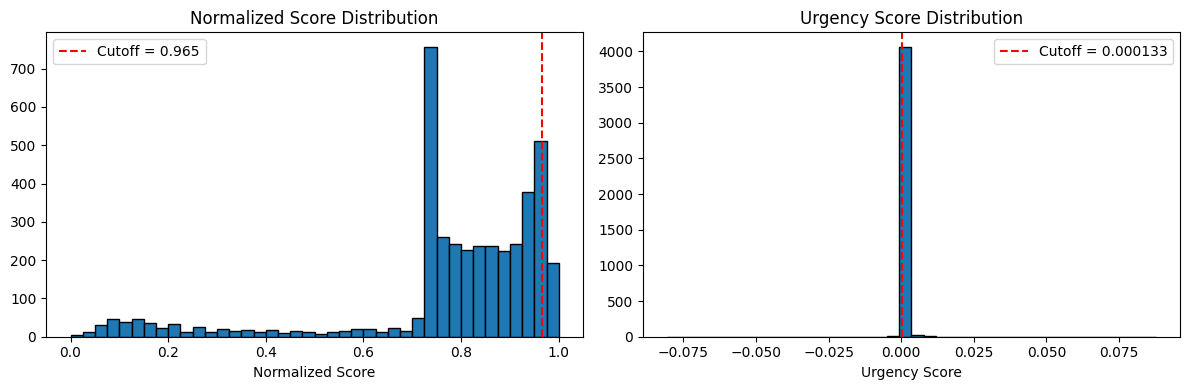

In [31]:
# 4) Plot distributions with thresholds
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(normalized_scores, bins=40, edgecolor='k')
plt.axvline(cut_norm, color='red', linestyle='--', label=f'Cutoff = {cut_norm:.3f}')
plt.title("Normalized Score Distribution")
plt.xlabel("Normalized Score")
plt.legend()

plt.subplot(1,2,2)
plt.hist(urgency_score, bins=40, edgecolor='k')
plt.axvline(cut_urg, color='red', linestyle='--', label=f'Cutoff = {cut_urg:.6f}')
plt.title("Urgency Score Distribution")
plt.xlabel("Urgency Score")
plt.legend()

plt.tight_layout()
plt.show()

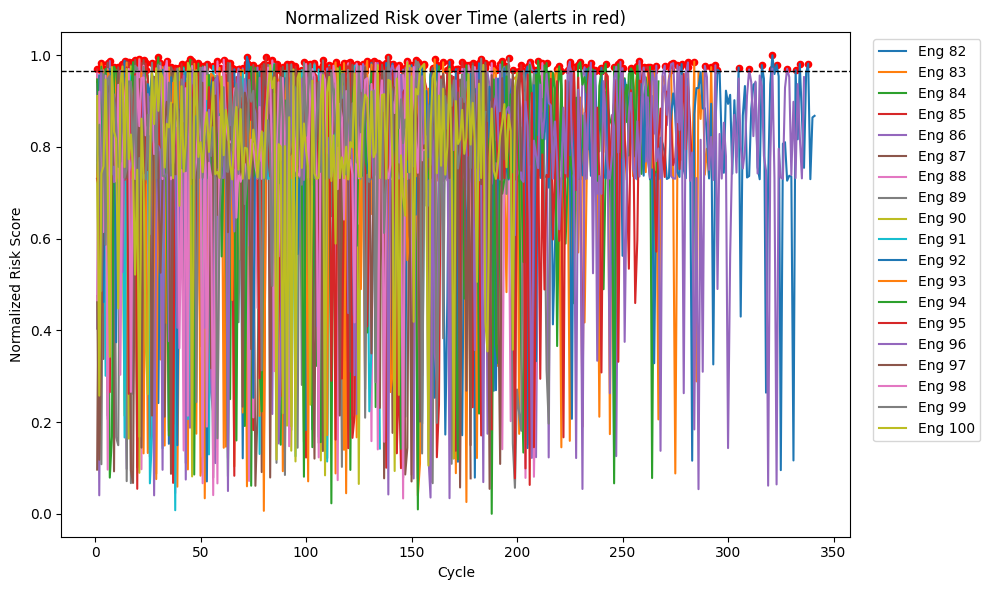

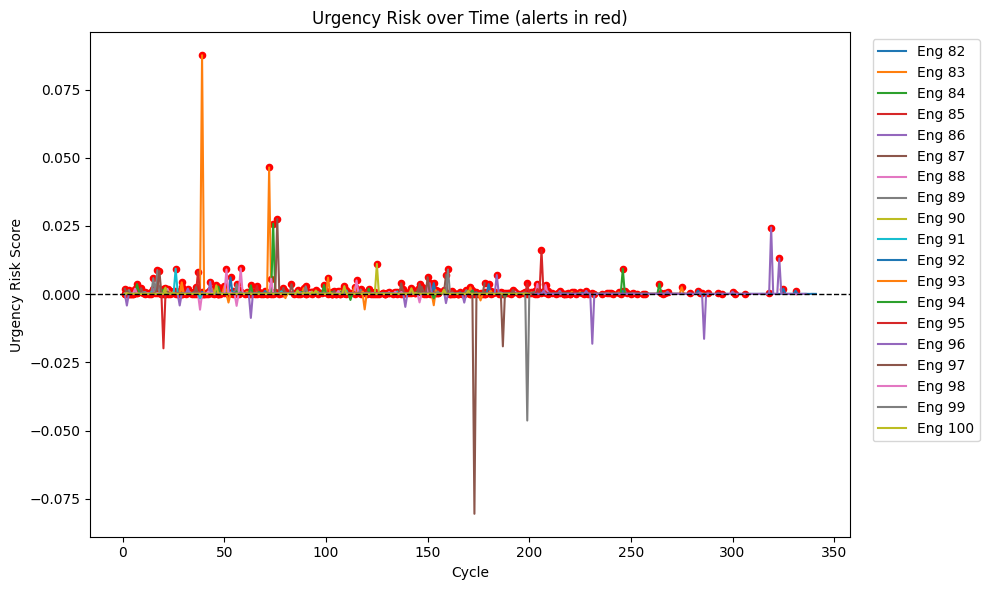

In [32]:
# 5) Apply thresholds to df_tail and plot time-series
df_tail['Alert_Norm']    = df_tail['Normalized_Risk_Score'] > cut_norm
df_tail['Alert_Urgency'] = df_tail['Urgency_Risk_Score']   > cut_urg

# Time-series for Normalized
plt.figure(figsize=(10,6))
for eng in df_tail['Engine no'].unique():
    eng_df = df_tail[df_tail['Engine no']==eng]
    plt.plot(eng_df['cycle'], eng_df['Normalized_Risk_Score'], label=f'Eng {eng}')
    over = eng_df[eng_df['Alert_Norm']]
    plt.scatter(over['cycle'], over['Normalized_Risk_Score'], color='red', s=20)
plt.axhline(cut_norm, color='black', linestyle='--', lw=1)
plt.xlabel('Cycle'); plt.ylabel('Normalized Risk Score')
plt.title('Normalized Risk over Time (alerts in red)')
plt.legend(bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

# Time-series for Urgency
plt.figure(figsize=(10,6))
for eng in df_tail['Engine no'].unique():
    eng_df = df_tail[df_tail['Engine no']==eng]
    plt.plot(eng_df['cycle'], eng_df['Urgency_Risk_Score'], label=f'Eng {eng}')
    over = eng_df[eng_df['Alert_Urgency']]
    plt.scatter(over['cycle'], over['Urgency_Risk_Score'], color='red', s=20)
plt.axhline(cut_urg, color='black', linestyle='--', lw=1)
plt.xlabel('Cycle'); plt.ylabel('Urgency Risk Score')
plt.title('Urgency Risk over Time (alerts in red)')
plt.legend(bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

In [33]:
alerts = normalized_scores > cut_urg
count = 0
for i, alert in enumerate(alerts):
    if alert:
        # print(f"⚠️ Maintenance Alert for Sample {i} | Score: {normalized_scores[i]:.3f}")
        count = count + 1
print(count)

4125


In [34]:
alerts = normalized_scores > cut_norm
count = 0
for i, alert in enumerate(alerts):
    if alert:
        # print(f"⚠️ Maintenance Alert for Sample {i} | Score: {normalized_scores[i]:.3f}")
        count = count + 1
print(count)

413
